In [82]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN
from utils import RAD_sampler, sample_collocation_points
from NavierStokesData import NavierStokesData

In [84]:
# Collocation points
Xc = sample_collocation_points(10000, 3, [1, -2, 0], [8, 2, 20], method='sobol')

In [ ]:
def compute_grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

class NavierStokes(torch.nn.Module):
    def __init__(self, lambda1, lambda2):
        super(NavierStokes, self).__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2


    def forward(self, Z, U):

        psi = U[:, 0:1]
        p = U[:, 1:2]

        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        u_z = compute_grad(u, Z)
        u_x = u_z[:, 0:1]
        u_y = u_z[:, 1:2]
        u_t = u_z[:, 2:3]

        v_z = compute_grad(v, Z)
        v_x = v_z[:, 0:1]
        v_y = v_z[:, 1:2]
        v_t = v_z[:, 2:3]

        p_z = compute_grad(p, Z)
        p_x = p_z[:, 0:1]
        p_y = p_z[:, 1:2]

        u_xx = compute_grad(u_x, Z)[:, 0:1]
        u_yy = compute_grad(u_y, Z)[:, 1:2]

        v_xx = compute_grad(v_x, Z)[:, 0:1]
        v_yy = compute_grad(v_y, Z)[:, 1:2]

        f = u_t + self.lambda1 * (u * u_x + v * u_y) + p_x - self.lambda2 * (u_xx + u_yy)
        g = v_t + self.lambda1 * (u * v_x + v * v_y) + p_y - self.lambda2 * (v_xx + v_yy)

        return torch.cat([f, g], dim=1)

lambda1 = 1.0
lambda2 = 0.01

N = NavierStokes(lambda1, lambda2)

In [ ]:
class NavierStokesUPINN(UPINN):
    
    def __init__(self):
        super(NavierStokesUPINN, self).__init__()
        
        left_bc = torch.linspace(-8, 8, 100).reshape(-1, 1)
        left_bc = torch.cat([torch.zeros_like(left_bc), left_bc], dim=1)




    def bc_loss(self):

        if self.data_points is not None:
            
            self.data_points[0].requires_grad_(True)

            Ud = self.u(self.data_points[0])

            psi_z = compute_grad(Ud[:, 0], self.data_points[0])
            psi_y = psi_z[:, 1:2]
            psi_x = psi_z[:, 0:1]

            data_pred = torch.cat([psi_y, -psi_x, Ud[:, 1:2]], dim=1)
            data_loss = torch.mean((data_pred - self.data_points[1][:, 0:3])**2)

            # self.log.setdefault("lambda1", []).append(lambda1.item())
            # self.log.setdefault("lambda2", []).append(lambda2.item())

        else: data_loss = torch.tensor(0.0)

        return data_loss
    
    def F_input(self, Z, U):
        
        psi = U[:, 0:1]
        
        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        return torch.cat([Z, u, v], dim=1)
    


In [2]:
import torch

In [ ]:
left_bc = torch.linspace(-8, 8, 100).reshape(-1, 1)
left_bc = torch.cat([torch.zeros_like(left_bc), left_bc], dim=1)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 100 but got size 10000 for tensor number 1 in the list.

In [4]:
left_bc

tensor([[ 0.0000, -8.0000],
        [ 0.0000, -7.8384],
        [ 0.0000, -7.6768],
        [ 0.0000, -7.5152],
        [ 0.0000, -7.3535],
        [ 0.0000, -7.1919],
        [ 0.0000, -7.0303],
        [ 0.0000, -6.8687],
        [ 0.0000, -6.7071],
        [ 0.0000, -6.5455],
        [ 0.0000, -6.3838],
        [ 0.0000, -6.2222],
        [ 0.0000, -6.0606],
        [ 0.0000, -5.8990],
        [ 0.0000, -5.7374],
        [ 0.0000, -5.5758],
        [ 0.0000, -5.4141],
        [ 0.0000, -5.2525],
        [ 0.0000, -5.0909],
        [ 0.0000, -4.9293],
        [ 0.0000, -4.7677],
        [ 0.0000, -4.6061],
        [ 0.0000, -4.4444],
        [ 0.0000, -4.2828],
        [ 0.0000, -4.1212],
        [ 0.0000, -3.9596],
        [ 0.0000, -3.7980],
        [ 0.0000, -3.6364],
        [ 0.0000, -3.4747],
        [ 0.0000, -3.3131],
        [ 0.0000, -3.1515],
        [ 0.0000, -2.9899],
        [ 0.0000, -2.8283],
        [ 0.0000, -2.6667],
        [ 0.0000, -2.5051],
        [ 0.0000, -2

In [87]:
hidden = [20] * 8

u = FNN(
    dims=[3, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[5, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [88]:
model = NavierStokesUPINN(u, N, data_points=(data.Zd, data.Ud), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


In [89]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3)
lbfgs = torch.optim.LBFGS(model.parameters(), lr=1)

In [90]:
model.optimizer = adamw
model.train_loop(1000)
model.optimizer = lbfgs
model.train_loop(500)

[Info]: Training 1000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.37 epoch/s, bc_loss=0.00e+00, data_loss=1.79e-02, pde_loss=3.48e-03, loss=2.14e-02]


[Info]: Training 500 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 500/500 [10:24<00:00,  1.25s/ epoch, bc_loss=0.00e+00, data_loss=6.67e-05, pde_loss=1.97e-04, loss=2.64e-04]


In [ ]:
model.train_loop(500)

[Info]: Training 500 epoch(s) on cuda using LBFGS optimizer.


[CUDA]:  82%|████████▏ | 412/500 [08:01<01:01,  1.44 epoch/s, bc_loss=0.00e+00, data_loss=3.94e-05, pde_loss=1.45e-04, loss=1.85e-04]

In [ ]:
model.train_loop(500)

[Info]: Training 500 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 500/500 [00:31<00:00, 15.82 epoch/s, bc_loss=0.00e+00, data_loss=5.50e-05, pde_loss=1.49e-04, loss=2.04e-04]


In [ ]:
model.save('nv-pinn-inviscid-500-with-preasuredata-10000-collocation', 'models')

[Info]: Successfully saved total model with name nv-pinn-inviscid-2000-with-preasuredata at models


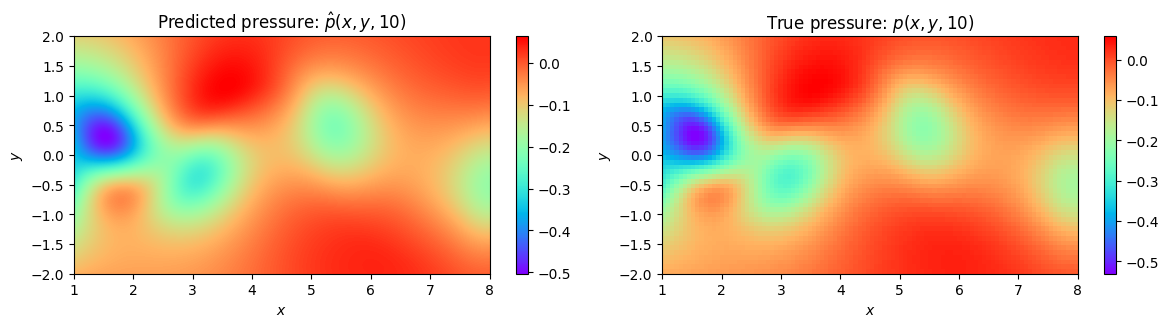

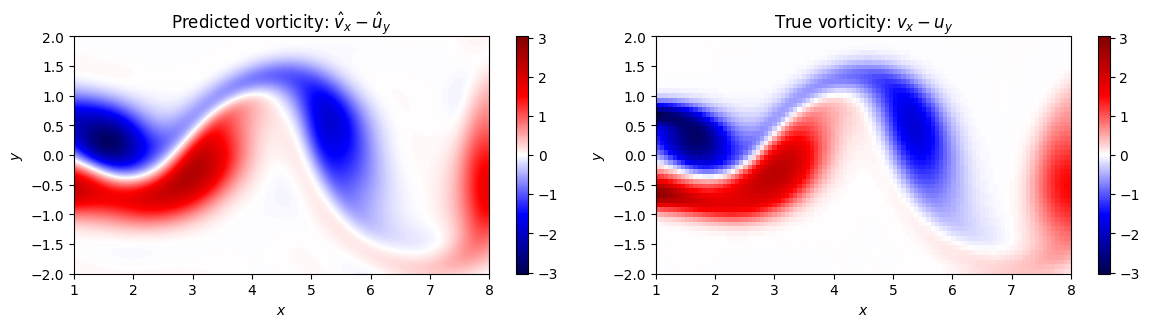

In [81]:
t = 10

# Predicted pressure at t
x = torch.linspace(1, 8, 1000)
y = torch.linspace(-2, 2, 1000)
X, Y = torch.meshgrid(x, y)
T = torch.ones_like(X) * t
Z = torch.stack([X, Y, T], dim=2).reshape(-1, 3).requires_grad_(True)
U = model.u(Z)
U_np = U.detach().numpy().reshape(*X.shape, 2)
P_pred = U_np[..., 1].T

# Predicted vorticity at t
dPsidZ = compute_grad(U[..., 0], Z)
dpsidx = dPsidZ[:, 0]
dpsidy = dPsidZ[:, 1]
u = dpsidy
v = -dpsidx
dudy = compute_grad(u, Z)[:, 1]
dvdx = compute_grad(v, Z)[:, 0]
omega_pred = dvdx - dudy
omega_pred = omega_pred.detach().numpy().reshape(*X.shape).T


# True pressure at t
mask = data.Zd_full[:, 2] == t
P_true = data.Ud_full[:, 2][mask].reshape(50,100)


# True vorticity at t
x_true = np.linspace(1, 8, 100)
y_true = np.linspace(-2, 2, 50)
u_true = data.Ud_full[:, 0][mask].reshape(50,100)
v_true = data.Ud_full[:, 1][mask].reshape(50,100)
dudy = np.gradient(u_true, y_true, axis=0)
dvdx = np.gradient(v_true, x_true, axis=1)
omega_true = dvdx - dudy




plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(P_pred, extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(1, 8)
plt.ylim(-2, 2)
# set equal aspect ratio
plt.gca().set_aspect('equal')
plt.title(r'Predicted pressure: $\hat{p}(x, y, 10)$')

plt.subplot(1, 2, 2)
plt.imshow(P_true, extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(1, 8)
plt.ylim(-2, 2)
# set equal aspect ratio
plt.gca().set_aspect('equal')
plt.title(r'True pressure: $p(x, y, 10)$')


plt.tight_layout()
# plt.savefig('gfx/nv-pinn-inverse-pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()


# True pressure at t
mask = data.Zd_full[:, 2] == t
P_true = data.Ud_full[:, 2][mask].reshape(50,100)

# True vorticity at t
u_true = data.Ud_full[:, 0][mask].reshape(50,100)
v_true = data.Ud_full[:, 1][mask].reshape(50,100)





v = max(np.max(abs(omega_pred)), np.max(abs(omega_true)))

plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(omega_pred, extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(1, 8)
plt.ylim(-2, 2)
# set equal aspect ratio
plt.gca().set_aspect('equal')
plt.title(r'Predicted vorticity: $\hat{v}_x - \hat{u}_y$')

plt.subplot(1, 2, 2)
plt.imshow(omega_true, extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(1, 8)
plt.ylim(-2, 2)
# set equal aspect ratio
plt.gca().set_aspect('equal')
plt.title(r'True vorticity: $v_x - u_y$')


plt.tight_layout()
# plt.savefig('gfx/nv-pinn-inverse-pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()




### Gags: Animate

In [ ]:
# # Animation over time
# import matplotlib.animation as animation

# fig, ax = plt.subplots()

# def animate(t):

#     # Predicted pressure at t
#     x = torch.linspace(1, 8, 1000)
#     y = torch.linspace(-2, 2, 1000)
#     X, Y = torch.meshgrid(x, y)
#     T = torch.ones_like(X) * t
#     Z = torch.stack([X, Y, T], dim=2).reshape(-1, 3)
#     U = u(Z)
#     U = U.detach().numpy().reshape(*X.shape, 2)
#     P_pred = U[..., 1].T

#     ax.clear()
#     ax.imshow(P_pred, extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
#     ax.set_xlabel(r'$x$')
#     ax.set_ylabel(r'$y$')
#     ax.set_xlim(1, 8)
#     ax.set_ylim(-2, 2)
#     ax.set_aspect('equal')
#     ax.set_title(r'Predicted pressure: $\hat{p}(x, y, %d)$' % t)

# ani = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 20, 200), interval=500, repeat=True)
# ani.save('gfx/nv-pinn-inverse-pressure.gif', writer='pillow', fps=20)
# plt.show()